/Users/RomanKoshkin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


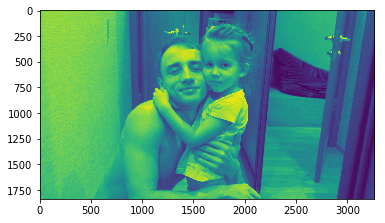

In [241]:
I = ndi.imread('/Users/RomanKoshkin/Documents/pictures/20151225_074357.jpg', flatten=False, mode=None)
I = I[:,:,0]
plt.imshow(I)
I = I.reshape(1, *I.shape)

/Users/RomanKoshkin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(1836, 3264, 3)


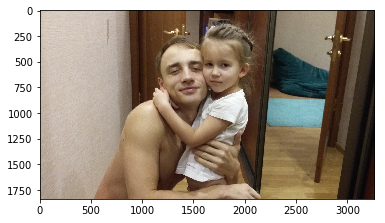

In [172]:
from scipy import ndimage as ndi
np.random.randint(10,size=(2,2))
I = ndi.imread('/Users/RomanKoshkin/Documents/pictures/20151225_074357.jpg', flatten=False, mode=None)
print(I.shape)
plt.imshow(I)

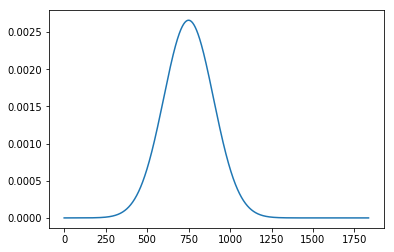

In [415]:
leng = 100
sigma = 150
mu_y = 1500
mu_x = 750
x = np.arange(I.shape[1])
# x_ = np.arange(mu_x - 2*sigma, mu_x + 2*sigma)
y = np.arange(I.shape[2])

px = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-np.power(x-mu_x,2)/(2*sigma**2)).reshape(x.shape[0],1)
py = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-np.power(y-mu_y,2)/(2*sigma**2)).reshape(I.shape[2],1)


plt.plot(x,px)

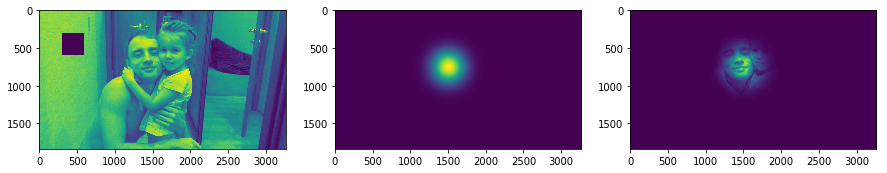

In [418]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(I.squeeze())

plt.subplot(1,3,2)
plt.imshow(np.dot(px, py.T))

plt.subplot(1,3,3)
plt.imshow(I.squeeze() * np.dot(px, py.T))

[[1000 1001 1002 ... 2833 2834 2835]]
[[-1000 -1001 -1002 ... -2833 -2834 -2835]
 [ -999 -1000 -1001 ... -2832 -2833 -2834]
 [ -998  -999 -1000 ... -2831 -2832 -2833]
 ...
 [ 2261  2260  2259 ...   428   427   426]
 [ 2262  2261  2260 ...   429   428   427]
 [ 2263  2262  2261 ...   430   429   428]]


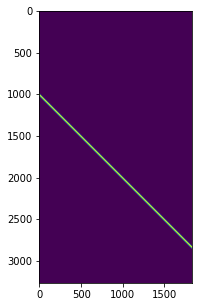

In [364]:
s = 10
u = 1000
d = 1
R, C = 1836, 3264
crop = 500

def mask(u, s, d, R, C, crop):
    mask = np.zeros((crop,C))
    R = np.arange(R).reshape(1,R)
    C = np.arange(C).reshape(C,1)
    centres = u + R * d
    print(centres)
    column_centres = C - centres
    print(column_centres)
    mask = np.exp(-.5 * np.square(column_centres / s))
    return mask

plt.figure(figsize=(15,5))
px = mask(u, s, d, R, C, crop)
plt.subplot(1,3,1)
plt.imshow(px)

# py = mask(u, s, d, R, C, crop)
# print(py.shape)
# plt.subplot(1,3,2)
# plt.imshow(py)

# c = np.matmul(np.matmul(px, I[0,:,:]), py.T)
# print(c.shape)
# plt.subplot(1,3,3)
# plt.imshow(c)

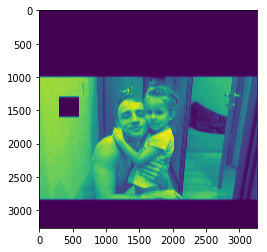

In [365]:
plt.imshow(np.matmul(px,I[0,:,:]))

## http://akosiorek.github.io/ml/2017/10/14/visual-attention.html

In [423]:
def gaussian_mask(u, s, d, R, C):    
    """
    :param u: tf.Tensor, centre of the first Gaussian.
    :param s: tf.Tensor, standard deviation of Gaussians.
    :param d: tf.Tensor, shift between Gaussian centres.
    :param R: int, number of rows in the mask, there is one Gaussian per row.
    :param C: int, number of columns in the mask.
    """
    # indices to create centres
    R = tf.to_float(tf.reshape(tf.range(R), (1, 1, R)))
    C = tf.to_float(tf.reshape(tf.range(C), (1, C, 1)))
    centres = u[np.newaxis, :, np.newaxis] + R * d
    column_centres = C - centres
    mask = tf.exp(-.5 * tf.square(column_centres / s))
    # we add eps for numerical stability
    normalised_mask = mask / (tf.reduce_sum(mask, 1, keep_dims=True) + 1e-8)
    return normalised_mask

def gaussian_glimpse(img_tensor, transform_params, crop_size):
    """
    :param img_tensor: tf.Tensor of size (batch_size, Height, Width, channels)
    :param transform_params: tf.Tensor of size (batch_size, 6), where params are  (mean_y, std_y, d_y, mean_x, std_x, d_x) specified in pixels.
    :param crop_size): tuple of 2 ints, size of the resulting crop
    """
    # parse arguments
    h, w = crop_size
    H, W = img_tensor.shape.as_list()[1:3]
    split_ax = transform_params.shape.ndims -1
    uy, sy, dy, ux, sx, dx = tf.split(transform_params, 6, split_ax)
    # create Gaussian masks, one for each axis
    Ay = gaussian_mask(uy, sy, dy, h, H)
    Ax = gaussian_mask(ux, sx, dx, w, W)
    # extract glimpse
    glimpse = tf.matmul(tf.matmul(Ay, img_tensor, adjoint_a=True), Ax)
    return glimpse

# def spatial_transformer(img_tensor, transform_params, crop_size):
#     """
#     :param img_tensor: tf.Tensor of size (batch_size, Height, Width, channels)
#     :param transform_params: tf.Tensor of size (batch_size, 4), where params are  (scale_y, shift_y, scale_x, shift_x)
#     :param crop_size): tuple of 2 ints, size of the resulting crop
#     """
#     constraints = snt.AffineWarpConstraints.no_shear_2d()
#     img_size = img_tensor.shape.as_list()[1:]
#     warper = snt.AffineGridWarper(img_size, crop_size, constraints)
#     grid_coords = warper(transform_params)
#     glimpse = snt.resampler(img_tensor[..., tf.newaxis], grid_coords)
#     return glimpse

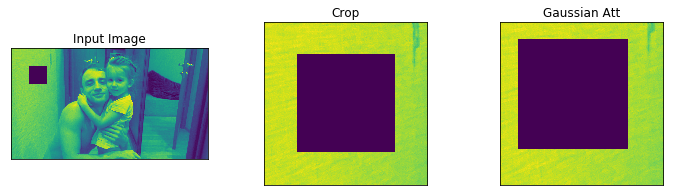

In [453]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img_size = I.squeeze().shape[0], I.squeeze().shape[1]
glimpse_size = 450, 450

# Create a random image with a square
# x = abs(np.random.randn(1, *img_size)) * .3
x = I
x[0, 300:600, 300:600] = 1
crop = x[0, 200:700, 200:700] # contains the square

tf.reset_default_graph()

# placeholders
tx = tf.placeholder(tf.float32, x.shape, 'image')
tu = tf.placeholder(tf.float32, [1], 'u')
ts = tf.placeholder(tf.float32, [1], 's')
td = tf.placeholder(tf.float32, [1], 'd')
stn_params = tf.placeholder(tf.float32, [1, 4], 'stn_params')

# Gaussian Attention
gaussian_att_params = tf.concat([tu, ts, td, tu, ts, td], -1)
gaussian_glimpse_expr = gaussian_glimpse(tx, gaussian_att_params, glimpse_size)

# # Spatial Transformer
# stn_glimpse_expr = spatial_transformer(tx, stn_params, glimpse_size)

sess = tf.Session()

# extract a Gaussian glimpse
u = 250
s = 0.1
d = 1
u, s, d = (np.asarray([i]) for i in (u, s, d))
gaussian_crop = sess.run(gaussian_glimpse_expr, feed_dict={tx: x, tu: u, ts: s, td: d})

# # extract STN glimpse
# transform = [.4, -.1, .4, -.1]
# transform = np.asarray(transform).reshape((1, 4))
# stn_crop = sess.run(stn_glimpse_expr, {tx: x, stn_params: transform})


# plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

titles = ['Input Image', 'Crop', 'Gaussian Att']
imgs = [x, crop, gaussian_crop]
for ax, title, img in zip(axes, titles, imgs):
    ax.imshow(img.squeeze())
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)